In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.optimize as opt
import copy
np.set_printoptions(threshold=np.inf, suppress=True, formatter={'float': '{: 0.8f}'.format}, linewidth=75)
%matplotlib inline

In [2]:
def kron(A, B):
    return la.kron(A, B)

In [3]:
def kronsum(A, B):
    if A.shape[0] != A.shape[1]:
        raise ValueError('A is not square')

    if B.shape[0] != B.shape[1]:
        raise ValueError('B is not square')
    
    L = kron(A, np.eye(B.shape[0]))
    R = kron(np.eye(A.shape[0]), B)
    
    return L+R

In [4]:
n = 3                   # Количество матриц D_k
p_num = 150             # Количество векторов стац. вероятн. p
eps_G = 10 ** (-6)      # Точность нахождения матр. G
eps_Phi = 10 ** (-6)    # Точность нахождения матр. Phi
eps_p_i = 10 ** (-6)    # Точность нахождения векторов p

In [5]:
# Входной BMAP
matrD_0 = np.array([[-86., 0.01], [0.02, -2.76]]) #* 0.025
matrD = np.array([[85, 0.99], [0.2, 2.54]]) #* 0.025
matrD_k = [matrD_0]

W_ = matrD_0.shape[0]
W = W_ - 1

q = 0.8
for k in range(1, n+1):
    matrD_k.append(matrD * (q ** (k-1)) * (1 - q) / (1 - q ** 3))

for matr in matrD_k:
    print(matr)

[[-86.00000000  0.01000000]
 [ 0.02000000 -2.76000000]]
[[ 34.83606557  0.40573770]
 [ 0.08196721  1.04098361]]
[[ 27.86885246  0.32459016]
 [ 0.06557377  0.83278689]]
[[ 22.29508197  0.25967213]
 [ 0.05245902  0.66622951]]


In [9]:
# Характеристики входного BMAP

matrD_1_ = np.zeros(matrD_k[0].shape)
for matr in matrD_k:
    matrD_1_ += matr
print('matrD_1_ =', matrD_1_)
matr_a = np.array(copy.deepcopy(matrD_1_))
for i in range(matr_a.shape[0]):
    matr_a[i][0] = 1

matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1

matr_a = np.transpose(matr_a)

theta = la.solve(matr_a, matr_b).reshape(-1)    # Алгоритм проверен.

matrdD_1_ = np.array(copy.deepcopy(matrD_k[1]))

print('Theta =', theta)

for i in range(2, n+1):
    matrdD_1_ += matrD_k[i] * i
vect_e = np.array([[1.] for i in range(0, matrD_1_.shape[1])])
lamD = np.dot(np.dot(theta, matrdD_1_), vect_e)[0]
print('lambda =', lamD)
lamDb = np.dot(np.dot(theta, -matrD_0), vect_e)[0]  # Средняя интенсивность прихода групп
print('\\lambda_b =', lamDb)

matrD_1_ = [[-1.00000000  1.00000000]
 [ 0.22000000 -0.22000000]]
Theta = [ 0.18032787  0.81967213]
lambda = 32.8853990863


In [12]:
c2var = np.sum(2*lamDb*(np.dot(theta, la.inv(-matrD_0)))) - 1   #c_{var}^2
print('c_{var}^2 =', c2var)

c_{var}^2 = 9.62142562303


In [15]:
c_cor = np.sum(lamDb * np.dot(np.dot(theta, la.inv(-matrD_0)), matrD_1_ - np.dot(matrD_0, la.inv(-matrD_0)))) - 1 / c2var
print(c_cor)

5.20677811003


In [8]:
# Поток поломок MAP
matrH0 = np.array([[-8.110725, 0], [0, -0.26325]]) / 3
matrH1 = np.array([[8.0568, 0.053925], [0.146625, 0.116625]]) / 3
V_ = matrH1.shape[0]
V = V_ - 1
matrH = matrH0 + matrH1
matr_a = copy.deepcopy(matrH)
for i in range(matr_a.shape[0]):
    # print(matr_a)
    matr_a[i][0] = 1
    
matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1

matr_a = np.transpose(matr_a)

print('H_0 =', matrH0)
print('H_1 =', matrH1)

gamma = la.solve(matr_a, matr_b).reshape(-1)

vect_e = np.array([[1.] for i in range(0, matrD_1_.shape[1])])
h = np.dot(np.dot(gamma, matrH1), vect_e)[0]
print('h =', h)

H_0 = [[-2.70357500  0.00000000]
 [ 0.00000000 -0.08775000]]
H_1 = [[ 2.68560000  0.01797500]
 [ 0.04887500  0.03887500]]
h = 2.00021741773


In [9]:
# Поток обслуживания PH1
beta1 = np.array([[1, 0]])
matrS1 = np.array([[-20, 20], [0, -20]])
M1 = matrS1.shape[0]
M1_ = M1 + 1
M1_e = np.array([[1] for _ in range(matrS1.shape[1])])
matrS1_0 = np.dot(- matrS1, M1_e)
vect_e = np.array([[1.] for i in range(0, matrS1.shape[1])])
# print(np.dot(beta1, la.inv(matrS1)))
mu_1 = -la.inv(np.dot(np.dot(beta1, la.inv(matrS1)), vect_e))[0, 0]
print(mu_1)

10.0


In [10]:
# Поток обслуживания PH2
beta2 = np.array([[1, 0]])
matrS2 = np.array([[-2, 2], [0, -2]])
M2 = matrS2.shape[0]
M2_ = M2 + 1
M2_e = np.array([[1] for _ in range(matrS2.shape[1])])
matrS2_0 = np.dot(- matrS2, M2_e)

vect_e = np.array([[1.] for i in range(0, matrS2.shape[1])])
mu_2 = -la.inv(np.dot(np.dot(beta2, la.inv(matrS2)), vect_e))[0, 0]
print(mu_2)

1.0


In [11]:
matrS_w = kron(np.dot(matrS1_0, beta1), 
               np.dot(M2_e, beta2)) + kron(np.dot(M1_e, beta1), np.dot(matrS2_0, beta2))

In [12]:
# Поток переключения с прибора-1 на прибор-2
alpha1 = np.array([[0.05, 0.95]])
matrA1 = np.array([[-1.86075, 0.], [0., -146.9994]])
L1 = matrA1.shape[0]
L1_ = L1 + 1
L1_e = np.array([[1] for _ in range(matrA1.shape[1])])
matrA1_0 = - np.dot(matrA1, L1_e)

vect_e = np.array([[1.] for i in range(0, matrA1.shape[1])])
kappa_1 = -la.inv(np.dot(np.dot(alpha1, la.inv(matrA1)), vect_e))[0, 0]
print(kappa_1)

29.9998528738


In [13]:
# Поток переключения с прибора-2 на прибор-1
alpha2 = np.array([[0.05, 0.95]])
matrA2 = np.array([[-5.58225, 0.], [0., -440.9982]])
L2 = matrA2.shape[0]
L2_ = L2 + 1
L2_e = np.array([[1] for _ in range(matrA2.shape[1])])
matrA2_0 = - np.dot(matrA2, L2_e)

vect_e = np.array([[1.] for i in range(0, matrA2.shape[1])])
kappa_2 = -la.inv(np.dot(np.dot(alpha2, la.inv(matrA2)), vect_e))[0, 0]
print(kappa_2)

89.9995586214


In [14]:
# Поток ремонта PH
tau = np.array([[0.98, 0.02]])
matrT = np.array([[-100, 0.], [0., -0.02]])
T_e = np.array([[1] for _ in range(matrT.shape[1])])
matrT0 = - np.dot(matrT, T_e)

R = matrT.shape[0]
R_ = R + 1
vect_e = np.array([[1.] for i in range(0, matrT.shape[1])])
phi = -la.inv(np.dot(np.dot(tau, la.inv(matrT)), vect_e))[0, 0]
print(phi)

0.990295107942


In [15]:
a = W_ * V_
print('a =', a)

a = 4


In [16]:
# Q~0
block00 = kronsum(matrD_k[0], matrH0)
block03 = kron(kron(kron(np.eye(W_), matrH1), tau), alpha1)
block10 = kron(np.eye(a), matrA2_0)
block11 = kronsum(kronsum(matrD_k[0], matrH0), matrA2)
block12 = kron(kron(kron(np.eye(W_), matrH1), tau), L2_e)
block21 = kron(kron(np.eye(a), matrT0), alpha2)
block22 = kronsum(kronsum(matrD_k[0], matrH), matrT)
block30 = kron(kron(np.eye(a), matrT0), L1_e)
block32 = kron(kron(np.eye(a), np.eye(R)), matrA1_0)
block33 = kronsum(kronsum(kronsum(matrD_k[0], matrH), matrT), matrA1)
block01 = np.zeros((block00.shape[0], block11.shape[1]))
block02 = np.zeros((block00.shape[0], block12.shape[1]))
block13 = np.zeros((block10.shape[0], block03.shape[1]))
block20 = np.zeros((block21.shape[0], block10.shape[1]))
block23 = np.zeros((block21.shape[0], block03.shape[1]))
block31 = np.zeros((block30.shape[0], block11.shape[1]))

print(block30.shape)

matrQw_0 = np.bmat([[block00, block01, block02, block03],
                    [block10, block11, block12, block13], 
                    [block20, block21, block22, block23],
                    [block30, block31, block32, block33]])
print(matrQw_0.shape)

(16, 4)
(36, 36)


In [17]:
# Q~k
matrQw_k = [matrQw_0]
for i in range(1, n+1):
    block0 = kron(kron(matrD_k[i], np.eye(V_)), beta1)
    block1 = kron(kron(kron(matrD_k[i], np.eye(V_)), beta2), np.eye(L2))
    block2 = kron(kron(kron(matrD_k[i], np.eye(V_)), beta2), np.eye(R))
    block3 = kron(kron(matrD_k[i], np.eye(V_)), np.eye(R*L1))
    matr_temp = la.block_diag(block0, block1, block2, block3)
    matrQw_k.append(matr_temp)
    
print(matrQw_k[0].shape)
print(matrQw_k[1].shape)

for i in range(matrQw_k[0].shape[0]):
    sum = 0
    for matr in matrQw_k:
        sum += np.sum(matr[i])
    # print('matrQw_k[' + str(i) + '] = ', sum)

(36, 36)
(36, 56)


In [18]:
# Q^0
block0 = kron(np.eye(a), matrS1_0)
block1 = kron(kron(np.eye(a), matrS2_0), np.eye(L2))
block2 = kron(kron(np.eye(a), matrS2_0), np.eye(R))
block3 = np.zeros((a*R*L1, a*R*L1))
matrQv_0 = la.block_diag(block0, block1, block2, block3)

print(matrQv_0.shape)

(56, 36)


In [19]:
# Q_0
block0 = kron(np.eye(a), np.dot(matrS1_0, beta1))
block1 = kron(kron(np.eye(a), np.dot(matrS2_0, beta2)), np.eye(L2))
block2 = kron(kron(np.eye(a), np.dot(matrS2_0, beta2)), np.eye(R))
block3 = np.zeros((a*R*L1, a*R*L1))
matrQ_0 = la.block_diag(block0, block1, block2, block3)

print(matrQ_0.shape)

(56, 56)


In [20]:
# Q_1
block00 = kronsum(kronsum(matrD_k[0], matrH0), matrS1)
block03 = kron(kron(kron(kron(np.eye(W_), matrH1), M1_e), tau), alpha1)
block10 = kron(kron(kron(np.eye(a), M2_e), beta1), matrA2_0)
block11 = kronsum(kronsum(kronsum(matrD_k[0], matrH0), matrS2), matrA2)
block12 = kron(kron(kron(kron(np.eye(W_), matrH1), np.eye(M2)), tau), L2_e)
block21 = kron(kron(kron(np.eye(a), np.eye(M2)), matrT0), alpha1)
block22 = kronsum(kronsum(kronsum(matrD_k[0], matrH), matrS2), matrT)
block30 = kron(kron(kron(np.eye(a), beta1), matrT0), L1_e)
block32 = kron(kron(kron(np.eye(a), beta2), np.eye(R)), matrA1_0)
block33 = kronsum(kronsum(kronsum(matrD_k[0], matrH), matrT), matrA1)
block01 = np.zeros((block00.shape[0], block11.shape[1]))
block02 = np.zeros((block00.shape[0], block12.shape[1]))
block13 = np.zeros((block10.shape[0], block03.shape[1]))
block20 = np.zeros((block21.shape[0], block10.shape[1]))
block23 = np.zeros((block21.shape[0], block03.shape[1]))
block31 = np.zeros((block30.shape[0], block11.shape[1]))

matrQ_1 = np.bmat([[block00, block01, block02, block03], 
                   [block10, block11, block12, block13], 
                   [block20, block21, block22, block23], 
                   [block30, block31, block32, block33]])

print(matrQ_1.shape)

(56, 56)


In [21]:
matrQ_k = [matrQ_0, matrQ_1]
for k in range(2, n+2):
    block0 = kron(matrD_k[k-1], np.eye(V_ * M1))
    block1 = kron(matrD_k[k-1], np.eye(V_*M2*L2))
    block2 = kron(matrD_k[k-1], np.eye(V_*M2*R))
    block3 = kron(matrD_k[k-1], np.eye(V_*R*L1))
    matr_temp = la.block_diag(block0, block1, block2, block3)
    matrQ_k.append(matr_temp)

# for i in range(matrQ_k[0].shape[0]):
#     sum = np.sum(matrQv_0[i])
#     for j in range(1, np.array(matrQ_k).shape[0]):
#         sum += np.sum(matrQ_k[j][i])
#     print('matrQ_k[' + str(i) + '] = ', sum)

In [22]:
# Проверка генератора Q

In [23]:
# Поиск матрицы G

matrQ_1_neg_inv = np.linalg.inv(-matrQ_k[1])


def calc_G(matrG_prev):
    temp_sum = np.array(copy.deepcopy(matrQ_k[0])) 
    for k in range(2, n + 2):
        temp_sum += np.dot(matrQ_k[k], np.linalg.matrix_power(matrG_prev, k))
    matrG_new = np.dot(matrQ_1_neg_inv, temp_sum)
    return matrG_new

matrG_old = np.eye(matrQ_k[1].shape[0])
matrG = calc_G(matrG_old)

i = 1
while la.norm(matrG - matrG_old, ord=np.inf) >= eps_G:
    matrG_old = matrG
    matrG = calc_G(matrG_old)
    i += 1
print(i)
print(la.norm(matrG, ord=np.inf))
print(matrG.shape)

305
1.000000000000029
(56, 56)


In [24]:
la.norm(matrG, ord=np.inf)

1.000000000000029

In [25]:
temp_sum = np.array(copy.deepcopy(matrQ_k[1]))
for k in range(2, n+2):
    temp_sum += np.dot(matrQ_k[k], np.linalg.matrix_power(matrG, k-1))
matrG_0 = la.inv(temp_sum)
matrG_0 = -np.dot(matrG_0, matrQv_0)
# pd.DataFrame(matrG_0)
la.norm(matrG_0, ord=np.inf)

1.0000000000000293

In [26]:
matrQ_il = []
for i in range(0, p_num):
    matrQ_il.append([])
    if i == 0:
        for l in range(0, n + 1):
            # здесь до n, т.к. нет больше матриц Q_k
            temp_matr = np.array(copy.deepcopy(matrQw_k[l]))
            for k in range(l + 1, n + 1):
                mult_matr = np.array(copy.deepcopy(matrQw_k[k]))
                for kk in range(k - 1, l - 1, -1):
                    if kk == 0:
                        mult_matr = np.dot(mult_matr, matrG_0)
                    else:
                        mult_matr = np.dot(mult_matr, matrG)
                print("mult matr 0 shape : ", mult_matr.shape)
                temp_matr += mult_matr
            matrQ_il[i].append(temp_matr)
        for l in range(n + 1, p_num):
            matrQ_il[i].append(np.zeros(matrQw_k[1].shape))
    else:
        for l in range(0, p_num):
            if l >= i and (l - i) <= (n + 1):
                if (l - i + 1) <= (n + 1): 
                    temp_matr = np.array(copy.deepcopy(matrQ_k[l - i + 1]))
                else:
                    temp_matr = np.zeros(matrQ_k[0].shape)
                    
                for k in range(l + 1, p_num):  # sum from l+1 to inf
                    if (k - i + 1) <= (n + 1):
                        mult_matr = np.array(copy.deepcopy(matrQ_k[k - i + 1]))
                        for kk in range(l, k):
                            mult_matr = np.dot(mult_matr, matrG)
                        
                        temp_matr += mult_matr
                matrQ_il[i].append(temp_matr)
            else:
                matrQ_il[i].append(np.zeros(matrQ_k[0].shape))

# print(len(matrQ_il[3]))
print(la.norm(matrQ_il[1][3], ord=np.inf))

mult matr 0 shape :  (36, 36)
mult matr 0 shape :  (36, 36)
mult matr 0 shape :  (36, 36)
mult matr 0 shape :  (36, 56)
mult matr 0 shape :  (36, 56)
mult matr 0 shape :  (36, 56)


1.2687049180328032


In [27]:
matrPhi_0 = np.eye(matrQ_il[0][0].shape[0])
matrPhi_l = [matrPhi_0]
for l in range(1, p_num):
    temp_matr = np.dot(np.dot(matrPhi_l[0], matrQ_il[0][l]), la.inv(-matrQ_il[l][l]))
    for i in range(1, l):
        # print(matrPhi_l[i].dot(matrQ_il[i][l]).dot(la.inv(-matrQ_il[l][l])).shape)
        temp_matr += np.dot(np.dot(matrPhi_l[i], matrQ_il[i][l]), la.inv(-matrQ_il[l][l]))
    matrPhi_l.append(temp_matr)
print(matrPhi_l[1].shape)

(36, 56)


In [28]:
print(la.norm(matrPhi_l[p_num - 1], ord=np.inf))

0.08808535464499025


In [29]:
# Вычисление p_0
matr_a = np.array(- copy.deepcopy(matrQ_il[0][0]))
vect_eaR = np.array([[1.] for _ in range(matrPhi_l[0].shape[1])])
for i in range(1, p_num):
    vect_e = np.array([[1.] for _ in range(matrPhi_l[i].shape[1])])
    vect_eaR += np.dot(matrPhi_l[i], vect_e)

for i in range(matr_a.shape[0]):
    matr_a[i][0] = vect_eaR[i][0]

matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1.
matr_a = np.transpose(matr_a)
p0 = np.transpose(la.solve(matr_a, matr_b))

# print(p0)
print(p0)

[[ 0.01630814  0.01208355  0.17902636  0.11046453  0.00011797  0.00005190
   0.00000274  0.00000090  0.00168685  0.00060301  0.00005113  0.00001259
   0.00024344  0.00069244  0.00000420  0.00006674  0.00275522  0.30795703
   0.00004274  0.07861995  0.00002091  0.00016586  0.00001100  0.00000565
   0.00000036  0.00000286  0.00000024  0.00000010  0.00023368  0.00183194
   0.00024723  0.00006280  0.00000365  0.00002844  0.00000598  0.00000098]]


In [30]:
vect_p_l = [p0]
p_sums = [np.sum(p0)]
print('p0 = ', vect_p_l[0][0])
print('sum0 = ', p_sums[0])
for l in range(1, p_num):
    vect_p_l.append(np.dot(vect_p_l[0], matrPhi_l[l]))
    p_sums.append(np.sum(vect_p_l[l]))
    print('p' + str(l) + ' = ', vect_p_l[l][0])
    print('sum' + str(l) + ' = ', p_sums[l])
print('sum = ', np.sum(p_sums))

p0 =  [ 0.01630814  0.01208355  0.17902636  0.11046453  0.00011797  0.00005190
  0.00000274  0.00000090  0.00168685  0.00060301  0.00005113  0.00001259
  0.00024344  0.00069244  0.00000420  0.00006674  0.00275522  0.30795703
  0.00004274  0.07861995  0.00002091  0.00016586  0.00001100  0.00000565
  0.00000036  0.00000286  0.00000024  0.00000010  0.00023368  0.00183194
  0.00024723  0.00006280  0.00000365  0.00002844  0.00000598  0.00000098]
sum0 =  0.713413108426
p1 =  [ 0.00228894  0.00184196  0.00145928  0.00131244  0.00082259  0.00072246
  0.00041651  0.00041329  0.00003508  0.00001359  0.00000622  0.00000037
  0.00000083  0.00000023  0.00000018  0.00000001  0.00001773  0.00000567
  0.00000465  0.00000057  0.00000085  0.00000019  0.00000056  0.00000011
  0.00006349  0.00051696  0.00000139  0.00024859  0.00000104  0.00008302
  0.00000002  0.00004072  0.00002440  0.01009618  0.00000061  0.00964345
  0.00000035  0.00266501  0.00000001  0.00257422  0.00000547  0.00004255
  0.00000527  0


p34 =  [ 0.00005780  0.00005098  0.00002216  0.00002208  0.00005000  0.00004409
  0.00002059  0.00002052  0.00000088  0.00000036  0.00000023  0.00000003
  0.00000003  0.00000001  0.00000002  0.00000000  0.00000076  0.00000031
  0.00000019  0.00000002  0.00000003  0.00000001  0.00000002  0.00000000
  0.00000163  0.00036869  0.00000004  0.00036955  0.00000002  0.00009000
  0.00000000  0.00009020  0.00000141  0.00031032  0.00000003  0.00031084
  0.00000002  0.00009468  0.00000000  0.00009513  0.00000014  0.00000111
  0.00000016  0.00000004  0.00000000  0.00000001  0.00000000  0.00000000
  0.00000012  0.00000096  0.00000014  0.00000003  0.00000000  0.00000001
  0.00000000  0.00000000]
sum34 =  0.00202642466812
p35 =  [ 0.00005712  0.00005038  0.00002195  0.00002187  0.00004943  0.00004359
  0.00002037  0.00002030  0.00000087  0.00000036  0.00000022  0.00000003
  0.00000003  0.00000001  0.00000002  0.00000000  0.00000075  0.00000031
  0.00000019  0.00000002  0.00000003  0.00000001  0.00000

 [ 0.00005260  0.00004639  0.00002051  0.00002044  0.00004564  0.00004025
  0.00001887  0.00001881  0.00000080  0.00000033  0.00000021  0.00000002
  0.00000003  0.00000001  0.00000002  0.00000000  0.00000069  0.00000029
  0.00000018  0.00000002  0.00000003  0.00000001  0.00000002  0.00000000
  0.00000149  0.00033341  0.00000004  0.00033413  0.00000002  0.00008596
  0.00000000  0.00008621  0.00000129  0.00028283  0.00000003  0.00028329
  0.00000002  0.00008733  0.00000000  0.00008776  0.00000013  0.00000101
  0.00000014  0.00000003  0.00000000  0.00000001  0.00000000  0.00000000
  0.00000011  0.00000088  0.00000012  0.00000003  0.00000000  0.00000001
  0.00000000  0.00000000]
sum42 =  0.00185245680659
p43 =  [ 0.00005198  0.00004585  0.00002031  0.00002024  0.00004513  0.00003980
  0.00001867  0.00001861  0.00000079  0.00000033  0.00000020  0.00000002
  0.00000003  0.00000001  0.00000002  0.00000000  0.00000068  0.00000028
  0.00000018  0.00000002  0.00000003  0.00000001  0.00000002  0.


sum91 =  0.00106817200602
p92 =  [ 0.00002953  0.00002604  0.00001216  0.00001213  0.00002591  0.00002285
  0.00001086  0.00001082  0.00000045  0.00000019  0.00000011  0.00000001
  0.00000002  0.00000000  0.00000001  0.00000000  0.00000039  0.00000016
  0.00000010  0.00000001  0.00000002  0.00000000  0.00000001  0.00000000
  0.00000084  0.00018329  0.00000002  0.00018360  0.00000001  0.00005593
  0.00000000  0.00005620  0.00000073  0.00015967  0.00000002  0.00015991
  0.00000001  0.00005127  0.00000000  0.00005154  0.00000007  0.00000057
  0.00000008  0.00000002  0.00000000  0.00000001  0.00000000  0.00000000
  0.00000006  0.00000050  0.00000007  0.00000002  0.00000000  0.00000001
  0.00000000  0.00000000]
sum92 =  0.00105622794
p93 =  [ 0.00002920  0.00002575  0.00001203  0.00001199  0.00002562  0.00002259
  0.00001074  0.00001070  0.00000044  0.00000018  0.00000011  0.00000001
  0.00000002  0.00000000  0.00000001  0.00000000  0.00000039  0.00000016
  0.00000010  0.00000001  0.000000


sum130 =  0.000688856102727
p131 =  [ 0.00001897  0.00001673  0.00000792  0.00000790  0.00001669  0.00001472
  0.00000702  0.00000700  0.00000029  0.00000012  0.00000007  0.00000001
  0.00000001  0.00000000  0.00000001  0.00000000  0.00000025  0.00000011
  0.00000006  0.00000001  0.00000001  0.00000000  0.00000001  0.00000000
  0.00000054  0.00011706  0.00000001  0.00011724  0.00000001  0.00003723
  0.00000000  0.00003742  0.00000047  0.00010270  0.00000001  0.00010285
  0.00000001  0.00003331  0.00000000  0.00003349  0.00000005  0.00000036
  0.00000005  0.00000001  0.00000000  0.00000000  0.00000000  0.00000000
  0.00000004  0.00000032  0.00000005  0.00000001  0.00000000  0.00000000
  0.00000000  0.00000000]
sum131 =  0.000681149573444
p132 =  [ 0.00001876  0.00001654  0.00000784  0.00000781  0.00001650  0.00001455
  0.00000694  0.00000692  0.00000028  0.00000012  0.00000007  0.00000001
  0.00000001  0.00000000  0.00000001  0.00000000  0.00000025  0.00000010
  0.00000006  0.00000001 

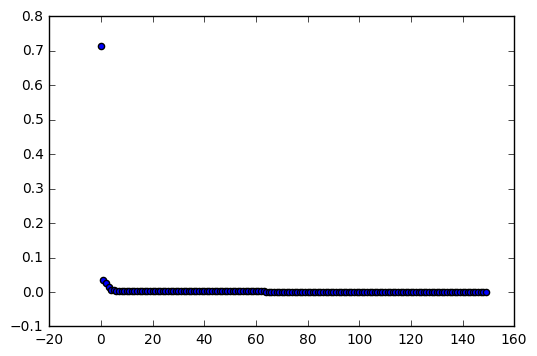

In [31]:
plt.scatter(x=[_ for _ in range(150)], y=p_sums)
plt.show()
# print(p_sums)

In [32]:
matr_Q_1_ = copy.deepcopy(matrQ_k[0])
for l in range(1, n+2):
    matr_Q_1_ += matrQ_k[l]

In [33]:
matr_dQ_1_ = copy.deepcopy(matrQ_k[1])
for l in range(2, n+2):
    matr_dQ_1_ += l * matrQ_k[l]

In [34]:
matr_a = copy.deepcopy(np.array(matr_Q_1_))
for i in range(matr_a.shape[0]):
    matr_a[i][0] = 1 
matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1
matr_a = np.transpose(matr_a)

vect_y = la.solve(matr_a, matr_b).reshape(-1)

In [35]:
vect_e = np.array([[1.] for _ in range(matr_dQ_1_.shape[1])])
ergodicity = np.dot(np.dot(vect_y, matr_dQ_1_), vect_e)[0, 0]
print('ergodicity =', ergodicity)

ergodicity = -3.2757671331


In [36]:
vect_e = [[1] for _ in range(matrQ_0.shape[1])]
denom = np.dot(np.dot(vect_y, matrQ_0), vect_e)[0]
rho = lamD / denom
print('\\rho =', rho)

\rho = 0.200623381193


In [37]:
# Условие эргодичности
block00 = kronsum(matrH0, matrS1) + kron(np.eye(V_), np.dot(matrS1_0, beta1))
block03 = kron(kron(kron(matrH1, M1_e), tau), alpha1)
block10 = kron(kron(np.eye(V_), np.dot(M2_e, beta1)), matrA2_0)
block11 = kronsum(kronsum(matrH0, matrS2), matrA2) + kron(kron(np.eye(V_), np.dot(matrS2_0, beta2)), np.eye(L2))
block12 = kron(kron(kron(matrH1, np.eye(M2)), tau), L2_e)
block21 = kron(kron(kron(np.eye(V_), np.eye(M2)), matrT0), alpha1)
block22 = kronsum(kronsum(matrH, matrS2), matrT) + kron(kron(np.eye(V_), np.dot(matrS2_0, beta2)), np.eye(R))
block30 = kron(kron(kron(np.eye(V_), beta1), matrT0), L1_e)
block32 = kron(kron(kron(np.eye(V_), beta2), np.eye(R)), matrA1_0)
block33 = kronsum(kronsum(matrH, matrT), matrA1)
block01 = np.zeros((block00.shape[0], block11.shape[1]))
block02 = np.zeros((block00.shape[0], block12.shape[1]))
block13 = np.zeros((block10.shape[0], block03.shape[1]))
block20 = np.zeros((block21.shape[0], block00.shape[1]))
block23 = np.zeros((block21.shape[0], block03.shape[1]))
block31 = np.zeros((block30.shape[0], block11.shape[1]))
matrGamma = np.bmat([[block00, block01, block02, block03],
                     [block10, block11, block12, block13],
                     [block20, block21, block22, block23],
                     [block30, block31, block32, block33]])
# pd.DataFrame(matrGamma)

In [38]:
matr_a = copy.deepcopy(np.array(matrGamma))
for i in range(matr_a.shape[0]):
    matr_a[i][0] = 1
matr_b = np.zeros((matr_a.shape[0], 1))
matr_b[0][0] = 1
matr_a = np.transpose(matr_a)

x = la.solve(matr_a, matr_b).reshape(-1)

print('x = ', x)
x1 = x[0:V_*M1]
x2 = x[V_*M1:V_*M1 + V_*M2*L2]
x3 = x[V_*M1 + V_*M2*L2: V_*M1 + V_*M2*L2 + V_*M2*R]

print('x1 = ', x1)
print('x2 = ', x2)
print('x3 = ', x3)

x =  [ 0.11981349  0.10554593  0.06831327  0.06801485  0.00175245  0.00073423
  0.00040251  0.00003038  0.00004836  0.00001404  0.00002197  0.00000314
  0.00339413  0.24970832  0.00007772  0.24665325  0.00005216  0.06621446
  0.00000112  0.06615319  0.00029430  0.00230619  0.00032246  0.00007907
  0.00000455  0.00003541  0.00000785  0.00000122]
x1 =  [ 0.11981349  0.10554593  0.06831327  0.06801485]
x2 =  [ 0.00175245  0.00073423  0.00040251  0.00003038  0.00004836  0.00001404
  0.00002197  0.00000314]
x3 =  [ 0.00339413  0.24970832  0.00007772  0.24665325  0.00005216  0.06621446
  0.00000112  0.06615319]


In [39]:
e_V_ = np.array([[1.] for i in range(0, V_)])
e_R = np.array([[1.] for i in range(0, R)])
pi1 = x1.dot(kron(e_V_, np.eye(M1)))
pi2 = x2.dot(kron(kron(e_V_, np.eye(M2)), L2_e))
pi3 = x3.dot(kron(kron(e_V_, np.eye(M2)), e_R))
print('pi1 = ', pi1)
print('pi2 = ', pi2)
print('pi3 = ', pi3)

pi1 =  [ 0.18812676  0.17356078]
pi2 =  [ 0.00254907  0.00045799]
pi3 =  [ 0.31936907  0.31288528]


In [40]:
varrho = np.dot(pi1, matrS1_0) + np.dot((pi2 + pi3), matrS2_0)
varrho = varrho[0]
print('\\varrho = ', varrho)

\varrho =  4.09790211025


In [41]:
vect_P_1_ = copy.deepcopy(vect_p_l[1])
for l in range(2, p_num):
    vect_P_1_ += vect_p_l[l]
print('P(1) =', vect_P_1_[0])

P(1) = [ 0.01262728  0.01111190  0.00629595  0.00626098  0.00668069  0.00589592
  0.00290627  0.00290056  0.00021431  0.00007973  0.00004936  0.00000378
  0.00000619  0.00000155  0.00000294  0.00000045  0.00011443  0.00004326
  0.00002964  0.00000339  0.00000482  0.00000121  0.00000328  0.00000067
  0.00036507  0.03866597  0.00000853  0.03769812  0.00000524  0.00980821
  0.00000011  0.00968224  0.00019201  0.05217041  0.00000462  0.05188238
  0.00000257  0.01516321  0.00000006  0.01518475  0.00003140  0.00024404
  0.00004630  0.00000840  0.00000045  0.00000349  0.00000117  0.00000012
  0.00001654  0.00012888  0.00002690  0.00000443  0.00000022  0.00000172
  0.00000070  0.00000006]


In [42]:
vect_dP_1_ = copy.deepcopy(vect_p_l[1])
for l in range(2, p_num):
    vect_dP_1_ += l * vect_p_l[l]

In [43]:
vect_ddP_1_ = copy.deepcopy(vect_p_l[2]) * 2
for l in range(3, p_num):
    vect_ddP_1_ += l * (l - 1) * vect_p_l[l]

In [44]:
# Среднее число запросов в системе

vect_e = np.array([[1.] for _ in range(vect_dP_1_.shape[1])])
L = np.dot(vect_dP_1_, vect_e)[0, 0]
print('L =', L)

L = 11.8254858553


In [45]:
# Дисперсия числа запросов в системе
dispV = np.dot(vect_ddP_1_, vect_e)[0] + L - L ** 2
dispV = dispV[0]
print('V =', dispV)

V = 840.94379103


In [46]:
# Вероятность того, что прибор 1 исправен и обслуживает запрос
temp_matr = np.dot(vect_P_1_, la.block_diag(np.eye(a*M1), np.zeros((a*(M2*L2 + M2*R + R*L1), a*(M2*L2 + M2*R + R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr.shape[1])])
prob1work = np.dot(temp_matr, vect_e)[0, 0]
print('P^{(1,0)} =', prob1work)

P^{(1,0)} = 0.0546795505195


In [47]:
# Вероятность того, что прибор-1 в неисправном состоянии и прибор-2 обслуживает запрос
temp_matr = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*M2*(L2 + R)), np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr.shape[1])])
prob1notwork = np.dot(temp_matr, vect_e)[0, 0]
print('P^{(2,0),(1,2)} =', prob1notwork)

P^{(2,0),(1,2)} = 0.231392525643


In [48]:
# Вероятность того, что в системе есть запросы, прибор 1 в неисправном состоянии и идет переключение с этого прибора на прибор 2 (при этом оба  прибора не обслуживают заявки)
temp_matr = np.dot(vect_P_1_, la.block_diag(np.zeros((a*(M1+M2*(L2+R)), a*(M1+M2*(L2+R)))), np.eye(a*R*L1)))
vect_e = np.array([[1.] for i in range(0, temp_matr.shape[1])])
prob1notworkswitch2 = np.dot(temp_matr, vect_e)[0, 0]
print('P^{(2,1)} =', prob1notworkswitch2)

P^{(2,1)} = 0.000514815411404


In [49]:
# Вероятность того, что в системе есть запросы, прибор 1 в исправном состоянии и идет переключение с  прибора 2 на прибор 1 (при этом прибор 2 продолжает обслуживать запросы)
temp_matr = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*M2*L2),
                                            np.zeros((a*(R*L1 + M2*R), a*(R*L1 + M2*R)))))
vect_e = np.array([[1.] for i in range(0, temp_matr.shape[1])])
prob1workswitch21 = np.dot(temp_matr, vect_e)[0, 0]
print('P^{(2,2)} =', prob1workswitch21)

P^{(2,2)} = 0.000559004440447


In [50]:
# Вероятность того, что прибор 1 доступен (средняя доля времени, в течение которого прибор 1 доступен)
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.eye(a*M1), np.zeros((a*(M2*L2 + M2*R + R*L1), a*(M2*L2 + M2*R + R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.eye(a), np.zeros((a*(L2+R+R*L1), a*(L2+R+R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)
prob1avail = temp_matr[0, 0]
print('P_1+ =', prob1avail)

P_1+ = 0.372562129255


In [51]:
# Вероятность того, что прибор 1 недоступен (средняя доля времени, в течение которого прибор 1 недоступен)
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*(M2*L2 + M2*R + R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a, a)), np.eye(a*(L2+R+R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)
prob1notavail = temp_matr[0, 0]
# print('P_2 =', prob1notavail)

In [52]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*M1, a*M1)), np.eye(a*M2*(L2+R)), np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a, a)), np.eye(a*(L2+R)), np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)

prob2_avail = temp_matr[0, 0]
print('P_2 =', prob2_avail)

P_2 = 0.624301385024


In [53]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*(M1+M2*(L2+R)), a*(M1+M2*(L2+R)))), np.eye(a*R*L1)))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a*(1+L2+R), a*(1+L2+R))), np.eye(a*R*L1)))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)

prob_both_not_avail = temp_matr[0, 0]
print('P- =', prob_both_not_avail)

P- = 0.00313648572031


In [54]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(kron(kron(np.eye(W_), matrH1), np.eye(M1)), np.zeros((a*(M2*(L2+R)+R*L1), a*(M2*(L2+R)+R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)

temp_matr2 = np.dot(vect_p_l[0], la.block_diag(kron(np.eye(W_), matrH1), np.zeros((a*(L2+R+R*L1), a*(L2+R+R*L1)))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)

switches12_num = temp_matr[0, 0]
print('Khi_1_2 =', switches12_num)

Khi_1_2 = 0.638648961285


In [ ]:
temp_matr1 = np.dot(vect_P_1_, la.block_diag(np.zeros((a*(M1+M2*L2), a*(M1+M2*L2))), kron(np.eye(a*M2), matrT),
                                             np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr1.shape[1])])
temp_matr = np.dot(temp_matr1, vect_e)
temp_matr2 = np.dot(vect_p_l[0], la.block_diag(np.zeros((a*(1+L2), a*(1+L2))), kron(np.eye(a), matrT),
                                               np.zeros((a*R*L1, a*R*L1))))
vect_e = np.array([[1.] for i in range(0, temp_matr2.shape[1])])
temp_matr += np.dot(temp_matr2, vect_e)
switches21_num = temp_matr[0, 0]
print('Khi_2_1 =', -switches21_num)